# Sparsity-promoting Dynamic Mode Decomposition (SpDMD)

#### This notebook calculates dominant spatio-temporal features in a dynamical process which are independent in frequency space. 
#### The dynamical process is represented by a number of spatial snapshots captured from experiments or numerical simulations at regular time intervals which may include noise. 
#### The analysis assumes that: 
1. the captured dynamical process is statistically stationary,
2. the snapshots are captured at regular time interval ($\Delta t$).

#### References:
1. http://www.ece.umn.edu/users/mihailo//software/dmdsp/index.html
2. https://en.wikipedia.org/wiki/Dynamic_mode_decomposition
3. https://doi.org/10.1017/S0022112010001217

#### Import libraries

In [1]:
import numpy as np 
import pandas as pd 
from scipy.fft import fftfreq, fft
from scipy import signal
import torch, torchvision
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt 
from tqdm import tqdm
from scipy.io import savemat,loadmat
import seaborn as sns

In [2]:
if (torch.cuda.is_available()):
    torch.set_default_device('cuda')

In [3]:
N = 1000 # Total number of snapshots
dt = 1e-5  # Time interval between two consecutive snapshots
nx = 704//4 # Image resolution in vertical direction. //4 means we'll coarse-grain the inmage resolution by a factor of 4.
ny = 1392//4 # Image resolution in horizontal direction. //4 means we'll coarse-grain the inmage resolution by a factor of 4.

# Empty array to store snapshot data
data = torch.empty((N,nx,ny),dtype=torch.double)

# Read all snapshots
for i in tqdm(range(N)):
    
    # Reading images in grayscale.
	image = read_image('./results/post/schlieren/10/image.{:0=8}.png'.format(50080+80*i),mode = ImageReadMode.GRAY)
    
	# Image crop box: 184,174 --> 1284,774
	# image = T.functional.crop(image,174,184,600,1500)
    
	image = T.Resize([nx,],antialias=True)(image) # Resizing image
    
	image = T.functional.convert_image_dtype(image, dtype=torch.double) # convert image data type to double for further computation
    
	data[i] = image    # Store processed images in the data array.

data = torch.flatten(data,1).T
data.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:10<00:00, 99.09it/s]


#### Compute SVD of snapshot matrix as first step of DMD (following reference 3)

In [5]:
U, S, vh = torch.linalg.svd(data[:,:-1], full_matrices=False)
print(U.shape)

torch.Size([61248, 1000])


#### Get Hessenberg matrix H

In [6]:
H = U.T@data[:,1:]

#### For Regual DMD, we could get eigen-values and eigen-vectors of H matrix right here.
#### However, Following reference 1, we need to solve an optimization problem to obtain a sparse set of eigen-values and eigen-vectors of DMD
#### For now we use the MATLAB code provided in reference 1 to get the sparse decomposition. An integrated phython version of the code will be implemented soon.
#### The matlab code takes the Hessenberg matrix H and eigen-values and eigen-vectors of SVD decomposition from earlier as input. So, we pack these data as a dictionary and write to a .mat file format which could be loaded in MATLAB.
#### The output of from the MATLAB code is saved as DMDsp.mat file which we load here to plot/vizualize results.

In [7]:
mdict = {"UstarX1": H.cpu(), "S": S.cpu(), "V": vh.T.cpu()}
savemat("./PODforDMDsp.mat",mdict)

In [8]:
dmdsp=loadmat("./DMDsp.mat")
print(dmdsp.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Edmd', 'Fdmd', 'Ydmd', 'answer', 'xdmd'])


#### Store matlab data in arrays:

gamma: refularization paramter that controls sparsity (see reference 1)

Nz: No of non-zero amplitudes in the optimal DMD decomposition

See MATLAB code for rest of the variables

In [9]:
gamma = dmdsp['answer'][0,0][0]
Nz = dmdsp['answer'][0,0][1]
jsp = dmdsp['answer'][0,0][2]
jpol = dmdsp['answer'][0,0][3]
Ploss = dmdsp['answer'][0,0][4]
xsp = dmdsp['answer'][0,0][5]
xpol = dmdsp['answer'][0,0][6]

#### Plot number of non-zero amplitude for each gamma value vs index of gamma value. Choose an index which has a value of Nz

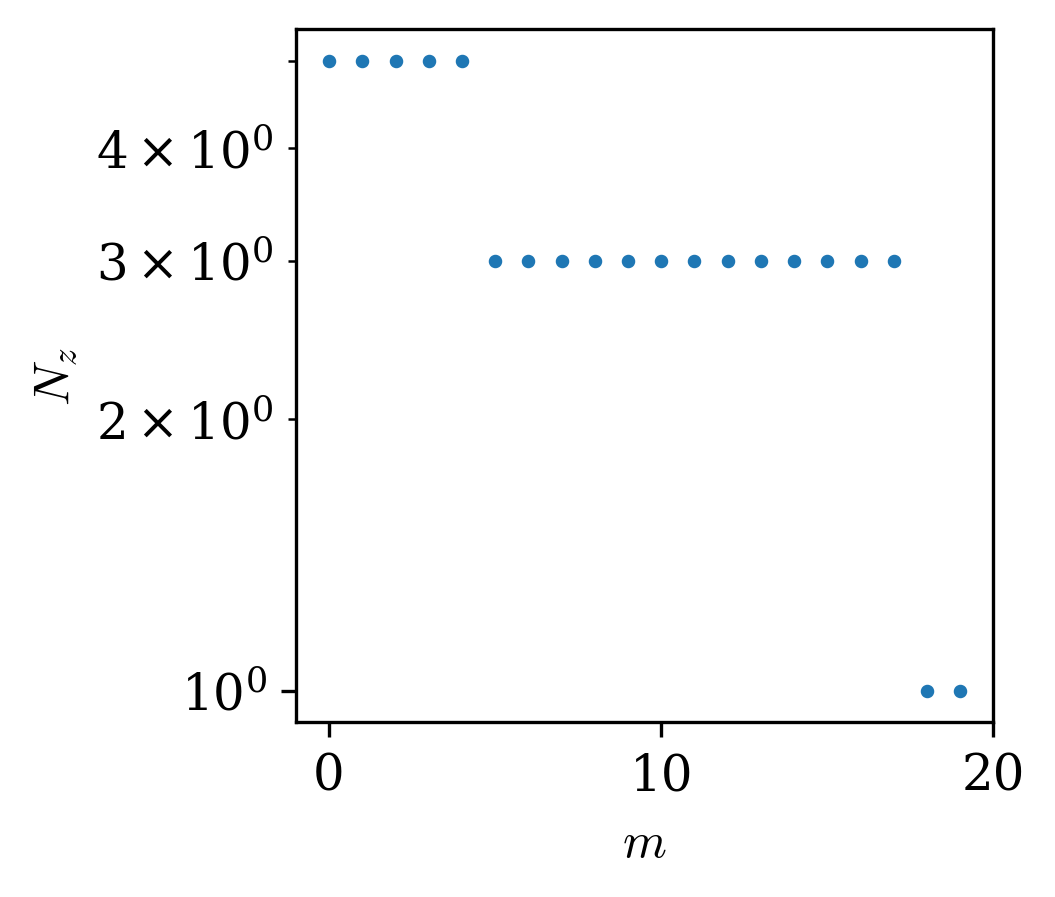

In [10]:
fig = plt.figure(figsize=(3,3),dpi=300)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 12})
plt.scatter(np.linspace(0,19,20),Nz,s=5)
plt.yscale('log')
plt.xlabel(r'$m$')
plt.xlim(-1,20)
plt.ylabel(r'$N_z$')
plt.savefig('./DMD_Nz.png')

#### Check eigen-values

In [11]:
idx=10
indices=np.nonzero(xsp[:,idx])
print(indices)
print(np.imag(np.log(dmdsp['Edmd'][indices,:]))\
                  *(1e5/(2*np.pi))*(0.05/900))
print(np.abs(dmdsp['Edmd'][indices,:]))

(array([444, 445, 722]),)
[[[ 0.36806839]
  [-0.36806839]
  [ 0.        ]]]
[[[1.00134203]
  [1.00134203]
  [1.00000071]]]


#### Plot eigen-values over a unit circle.

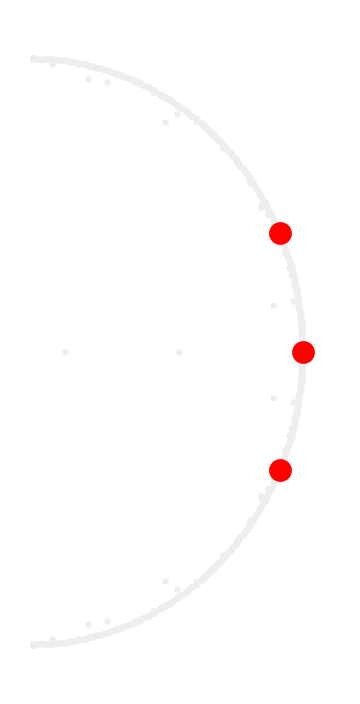

In [16]:
COLOR='#eeeeee'
fig = plt.figure(figsize=(1.15,2.3),dpi=300)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 5})
plt.rcParams['axes.edgecolor'] = COLOR
plt.scatter(np.real(dmdsp['Edmd']),np.imag(dmdsp['Edmd']),color=COLOR,s=0.3)
plt.scatter(np.real(dmdsp['Edmd'][indices,:]),\
            np.imag(dmdsp['Edmd'][indices,:]),color='red',s=20)
plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')
plt.xlim(0,1.1)
plt.ylim(-1.1,1.1)
plt.axis('off')
plt.tight_layout()
plt.savefig('./DMD_spectra.png',transparent=True)

#### Project eigen-vector in physical space.

In [13]:
phi = U.cpu()@dmdsp['Ydmd'][:,indices[0]]

#### Plot first dominant DMD mode.

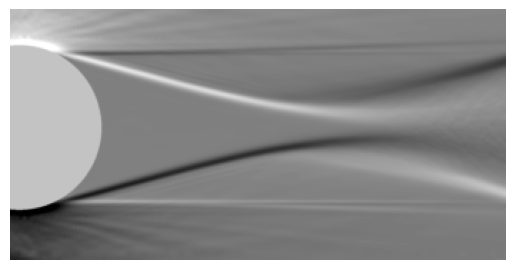

In [14]:
plt.imshow(abs(phi[:,2].reshape(nx,ny)),cmap='gray')
plt.axis('off')
plt.savefig("Mode1.png", bbox_inches='tight')

#### Plot second dominant DMD mode.

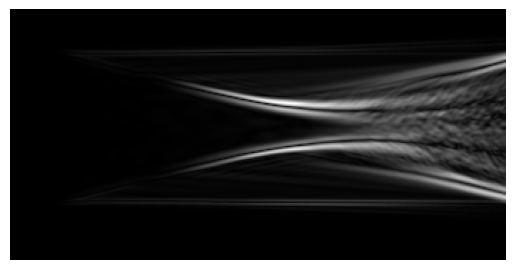

In [15]:
plt.imshow(abs(phi[:,0].reshape(nx,ny)),cmap='gray')
plt.axis('off')
plt.savefig("Mode2.png", bbox_inches='tight')